# Hospital Readmission 
## Objective

A hospital readmission is an episode when a patient who had been discharged from a hospital is admitted again within a specified time interval. Reducing hospital readmissions—especially those that result from poor inpatient or outpatient care—has long been a health policy goal because it represents an opportunity to lower health care costs, improve quality, and increase patient satisfaction at once. This project has been aimed towards building a predictive modelling system that predicts hospital readmissions for a patient diagnosed with COPD, within 30 days. 

## COPD

Chronic obstructive pulmonary disease (COPD) is a chronic inflammatory lung disease that causes obstructed airflow from the lungs. Symptoms include breathing difficulty, cough, mucus (sputum) production and wheezing.People with COPD are at increased risk of developing heart disease, lung cancer and a variety of other conditions.

Emphysema and chronic bronchitis are the two most common conditions that contribute to COPD. These two conditions usually occur together and can vary in severity among individuals with COPD.

## Why COPD

Chronic obstructive pulmonary disease (COPD) is the third leading cause of death worldwide and has an associated treatment cost of $9,800 per patient per year in the US.1–3 Within 5 years of hospital discharge for a COPD exacerbation, the rehospitalization risk is 44%, and the mortality rate is 55.4% COPD affects more than 11 million Americans, and the disease prevalence among US veterans is 3-fold higher.

Patients hospitalized for COPD have a 30-day readmission rate of 22.6%

## Dataset being studied

The dataset being studied is the CMS linkable 2008–2010 Medicare Data Entrepreneurs’ Synthetic Public Use File (DE-SynPUF) which is publically available online. The data are fully “synthetic,” meaning no beneficiary in the DE-SynPUF is an actual Medicare beneficiary. The data set containse 20 samples for the years 2008-2010 and each sample has 5 types of files.
- CMS Beneficiary Summary DE-SynPUF
- CMS Inpatient Claims DE-SynPUF
- CMS Outpatient Claims DE-SynPUF
- CMS Carrier Claims DE-SynPUF (also known as the Physician/Supplier Part B claims file)
- CMS Prescription Drug Events (PDE) DE-SynPUF

### Inclusion Criteria


- Since people suffering from COPD experience asthamtic and exacerbative symptoms, the following ICD-9 codes ranging   from 490 to 496 were taken into consideration.

1. 490 : Bronchitis, not specified as acute or chronic
2. 491 : Chronic bronchitis
3. 492 : Emphysema
4. 493 : Asthma
5. 494 : Bronchiectasis
6. 495 : Extrinsic allergic alveolitis
7. 496 : Chronic airway obstruction, not elsewhere classified
8. 518.81 : Acute respiratory failure
9. 518.82 : Other pulmonary insufficiency not elsewhere classified
10. 518.84 : Acute and chronic respiratory failure
11. 799.10 : Respiratory arrest

- Patients getting readmitted within 30 days who are still living.

### Exclusion Criteria 

- Patients with age below 60
- The prescription, outpatient and carrier claims datasets.


# Preparing the Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot
from imblearn.over_sampling import SMOTE

import scikitplot.metrics as skplt

pd.set_option("display.max_columns", None)
sns.color_palette("pastel")
sns.set_theme(palette="pastel", style="dark")

In [2]:
df1 = pd.read_csv("data/DE1_0_2008_Beneficiary_Summary_File_Sample_1.csv")
df2 = pd.read_csv("data/DE1_0_2008_Beneficiary_Summary_File_Sample_2.csv")
df3 = pd.read_csv("data/DE1_0_2008_Beneficiary_Summary_File_Sample_3.csv")
dft = pd.concat([df1,df2,df3], ignore_index=True)

In [39]:
dfX = dft.drop(columns=['BENE_ESRD_IND', 'BENE_HI_CVRAGE_TOT_MONS', 'BENE_SMI_CVRAGE_TOT_MONS',
       'BENE_HMO_CVRAGE_TOT_MONS', 'PLAN_CVRG_MOS_NUM', 'SP_CHRNKIDN', 'SP_CNCR','SP_ALZHDMTA', 'SP_CHRNKIDN', 'SP_RA_OA', 'MEDREIMB_IP', 'BENRES_IP', 'PPPYMT_IP', 'MEDREIMB_OP', 'BENRES_OP',
       'PPPYMT_OP', 'MEDREIMB_CAR', 'BENRES_CAR', 'PPPYMT_CAR'])
df = dfX[dfX['BENE_DEATH_DT'].isnull()].drop(columns=['BENE_DEATH_DT']).reset_index().drop(columns=['index'])

# Some EDA

### Gender-Race Crosstab

In [4]:
df["BENE_SEX_IDENT_CDx"] = df.BENE_SEX_IDENT_CD.replace([1,2], ["Male", "Female"])
df["BENE_RACE_CDx"] = df.BENE_RACE_CD.replace([1,2,3,5], ["White", "Black", "Other", "Hispanic"])

pd.crosstab(df["BENE_RACE_CDx"], df["BENE_SEX_IDENT_CDx"])

BENE_SEX_IDENT_CDx,Female,Male
BENE_RACE_CDx,,
Black,20576,15730
Hispanic,4446,3711
Other,7900,6633
White,157951,126853


### Graph denoting birth years for different races and genders

<AxesSubplot:xlabel='BENE_RACE_CDx', ylabel='BENE_BIRTH_DTx'>

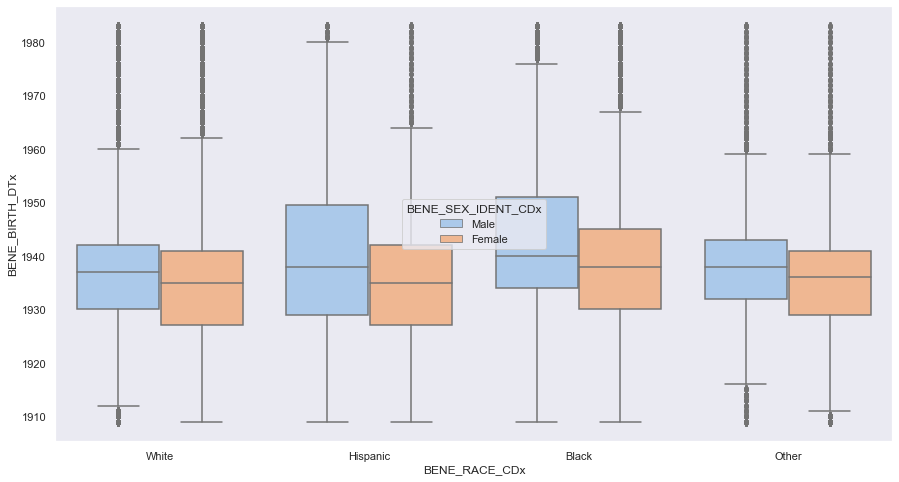

In [5]:
df["BENE_BIRTH_DTx"] = [str(x) for x in df["BENE_BIRTH_DT"]]
df["BENE_BIRTH_DTx"] = [x[:4] for x in df["BENE_BIRTH_DTx"]]
df["BENE_BIRTH_DTx"] = [int(x) for x in df["BENE_BIRTH_DTx"]]

fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(y=df.BENE_BIRTH_DTx, x=df.BENE_RACE_CDx, hue=df.BENE_SEX_IDENT_CDx, ax=ax)

### Using bins

In [38]:
df["BENE_BIRTH_DTx"] = df["BENE_BIRTH_DTx"].dropna(0)
df["BENE_BIRTH_DTx2"] = pd.cut(df["BENE_BIRTH_DTx"], [1900,1924,1929,1934,1939,1943,1970], labels=["Pre-1924","1924-1928","1929-1933","1934-1938","1939-1942","Post-1943"])
dfx = df.groupby(["BENE_BIRTH_DTx2", "SP_COPD", "BENE_SEX_IDENT_CDx"])["BENE_RACE_CDx"].value_counts().unstack().apply(lambda x: x/x.sum()*100, axis=1)
dfx

/var/folders/7v/5bjjg3ds57g4cvrlx_ny2qvr0000gp/T/ipykernel_8109/3685669400.py:1: FutureWarning: In a future version of pandas all arguments of Series.dropna will be keyword-only
  df["BENE_BIRTH_DTx"] = df["BENE_BIRTH_DTx"].dropna(0)


BENE_RACE_CDx                                   Black  Hispanic     Other  \
BENE_BIRTH_DTx2 SP_COPD BENE_SEX_IDENT_CDx                                  
Pre-1924        1       Female               7.737725  1.880050  2.548167   
                        Male                 5.587610  1.822047  2.763438   
                2       Female               8.309577  2.259529  3.801077   
                        Male                 7.053683  3.128034  3.835483   
1924-1928       1       Female               7.556912  2.299930  2.581554   
                        Male                 5.475605  2.106002  2.808003   
                2       Female               8.391795  3.094752  3.592043   
                        Male                 7.397016  2.926923  3.456192   
1929-1933       1       Female               8.824209  2.079002  3.326403   
                        Male                 6.880190  1.423488  4.003559   
                2       Female               9.448760  2.075125  4.525498   
                        Male                 7.867709  1.955149  4.192971   
1934-1938       1       Female               9.355132  1.861944  3.633061   
                        Male                 8.821011  1.455895  3.511276   
                2       Female               9.819731  1.836409  4.755043   
                        Male                 8.731227  1.611646  4.732219   
1939-1942       1       Female              10.607832  1.694915  3.974284   
                        Male                 8.356071  1.909959  3.649386   
                2       Female              10.040057  1.886549  4.994185   
                        Male                 9.475720  1.797737  5.353818   
Post-1943       1       Female              20.264080  2.991108  2.964161   
                        Male                18.399264  2.882551  4.354492   
                2       Female              20.004040  3.136205  3.817989   
                        Male                18.749439  3.553140  4.195490   

BENE_RACE_CDx                                   White  
BENE_BIRTH_DTx2 SP_COPD BENE_SEX_IDENT_CDx             
Pre-1924        1       Female              87.834058  
                        Male                89.826906  
                2       Female              85.629817  
                        Male                85.982799  
1924-1928       1       Female              87.561605  
                        Male                89.610390  
                2       Female              84.921410  
                        Male                86.219870  
1929-1933       1       Female              85.770386  
                        Male                87.692764  
                2       Female              83.950617  
                        Male                85.984170  
1934-1938       1       Female              85.149864  
                        Male                86.211818  
                2       Female              83.588816  
                        Male                84.924908  
1939-1942       1       Female              83.722969  
                        Male                86.084584  
                2       Female              83.079209  
                        Male                83.372726  
Post-1943       1       Female              73.780652  
                        Male                74.363692  
                2       Female              73.041766  
                        Male                73.501932

## A few commorbities faced by COPD patients

### 1. Cardiovascular Disease
Various forms of cardiovascular disease, including hypertension, coronary artery disease, and heart failure, are the most common and most notable COPD comorbidities. Patients with COPD had 2.5 times higher odds of developing any form of cardiovascular disease.
### 2. Diabetes and Metabolic Syndrome
The prevalence of diabetes among COPD patients ranges from 10% to 19%. The prevalence of metabolic syndrome among COPD patients has been estimated to be between 20% and 50%, depending on COPD severity.
### 3. Osteoporosis
Osteoporosis results in reduced bone density and increased risk for bone fractures. Declining health status due to older age increases risk for both osteoporosis and COPD.
### 4. Lung Cancer
Symptoms of COPD, such as obstructed airflow, respiratory exacerbations in the past year, and visual emphysema, have been shown to increase the odds of developing lung cancer.
### 5. Depression
Mood disorders, particularly depression, are common among individuals with COPD. The prevalence of depression among individuals with COPD is estimated to range from 20% to 60%, depending on COPD severity and screening techniques. 
### 6. Sleep Disorders
Approximately 10% of COPD patients have obstructive sleep apnea and about 20% of people with sleep apnea are also diagnosed with COPD. In general, patients with COPD often report greater sleep disturbances than individuals without COPD, including interrupted sleep and less deep sleep.

#### In the lines below, a gender wise distribution of the different commordities mentioned above is carried out.

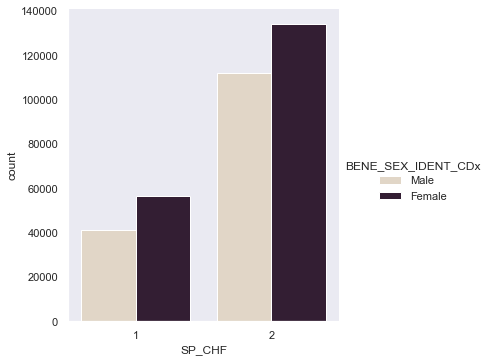

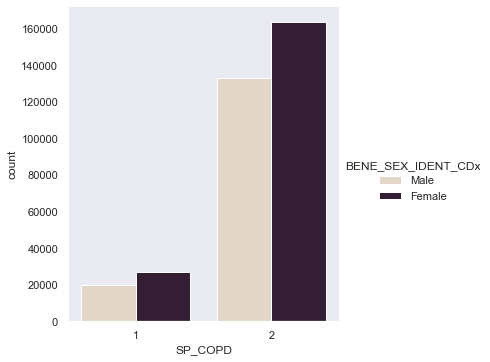

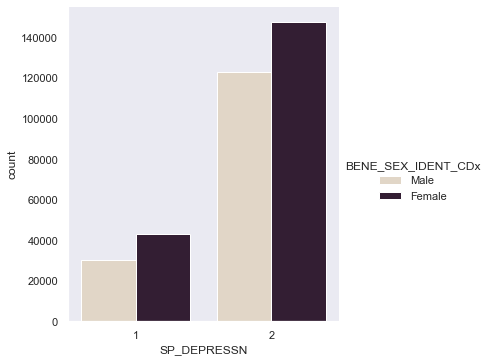

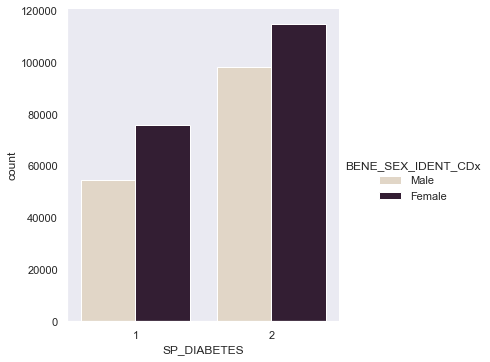

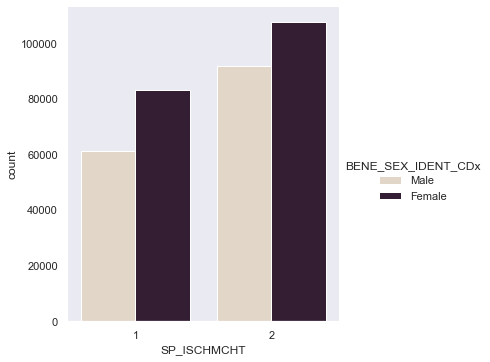

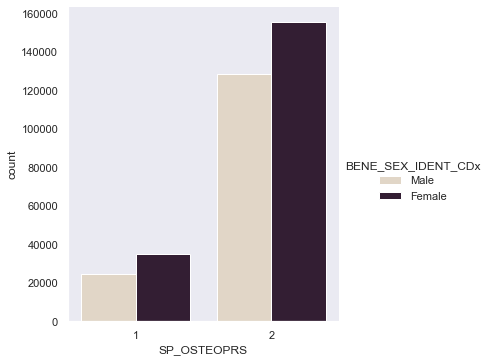

In [7]:
dfx = df.iloc[:,6:12]
dfx["BENE_SEX_IDENT_CDx"] = df["BENE_SEX_IDENT_CDx"]
columns = np.array(dfx.columns)
for i in range(len(columns)-1):
    sns.catplot(x=columns[i], kind="count", hue="BENE_SEX_IDENT_CDx" ,palette="ch:.25", data=dfx)

From the finding we concur that the female count for each of the disease is higher than the male count. Also in the case of COPD, the ratio of people from the sample who have the disease to who don't have the disease is rougly 19:100 

## Integrating Inpatient data

In [8]:
da = pd.read_csv("data/DE1_0_2008_to_2010_Inpatient_Claims_Sample_1.csv")
da2 = pd.read_csv('data/DE1_0_2008_to_2010_Inpatient_Claims_Sample_2.csv')
da3 = pd.read_csv('data/DE1_0_2008_to_2010_Inpatient_Claims_Sample_3.csv')
da = pd.concat([da,da2,da3], ignore_index=True)

Since any columns regrading payment is not influential to our goal, we have chosen to drop it. This includes any columns ending with AM or AMT. Other columns that will be droped include :

- Any columns ending with NPI or NUM since the Npin for a a physician has no possible links in the future or to other   

In [9]:
da = da.drop(columns=['PRVDR_NUM', 'CLM_PMT_AMT','CLM_FROM_DT' ,'SEGMENT' ,'CLM_THRU_DT' , 'NCH_PRMRY_PYR_CLM_PD_AMT', 'AT_PHYSN_NPI',
       'OP_PHYSN_NPI', 'OT_PHYSN_NPI','CLM_PASS_THRU_PER_DIEM_AMT', 'NCH_BENE_IP_DDCTBL_AMT',
       'NCH_BENE_PTA_COINSRNC_LBLTY_AM', 'NCH_BENE_BLOOD_DDCTBL_LBLTY_AM','HCPCS_CD_1', 'HCPCS_CD_2',
       'HCPCS_CD_3', 'HCPCS_CD_4', 'HCPCS_CD_5', 'HCPCS_CD_6', 'HCPCS_CD_7',
       'HCPCS_CD_8', 'HCPCS_CD_9', 'HCPCS_CD_10', 'HCPCS_CD_11', 'HCPCS_CD_12',
       'HCPCS_CD_13', 'HCPCS_CD_14', 'HCPCS_CD_15', 'HCPCS_CD_16',
       'HCPCS_CD_17', 'HCPCS_CD_18', 'HCPCS_CD_19', 'HCPCS_CD_20',
       'HCPCS_CD_21', 'HCPCS_CD_22', 'HCPCS_CD_23', 'HCPCS_CD_24',
       'HCPCS_CD_25', 'HCPCS_CD_26', 'HCPCS_CD_27', 'HCPCS_CD_28',
       'HCPCS_CD_29', 'HCPCS_CD_30', 'HCPCS_CD_31', 'HCPCS_CD_32',
       'HCPCS_CD_33', 'HCPCS_CD_34', 'HCPCS_CD_35', 'HCPCS_CD_36',
       'HCPCS_CD_37', 'HCPCS_CD_38', 'HCPCS_CD_39', 'HCPCS_CD_40',
       'HCPCS_CD_41', 'HCPCS_CD_42', 'HCPCS_CD_43', 'HCPCS_CD_44',
       'HCPCS_CD_45','ICD9_PRCDR_CD_1',
       'ICD9_PRCDR_CD_2', 'ICD9_PRCDR_CD_3', 'ICD9_PRCDR_CD_4',
       'ICD9_PRCDR_CD_5', 'ICD9_PRCDR_CD_6'])

Selecting only those rows with matching the ICD-9 codes mentioned in the inclusion criteria that was earlier finalised on.

In [10]:
dax = da.loc[da['CLM_DRG_CD'].isin(['490','491','492','493','494','495','496'])].reset_index().drop(columns=['index'])
temp = dax
temp = temp.set_index(['DESYNPUF_ID'])

In [11]:
cms = np.array(da.columns)
res = pd.DataFrame()
for i in cms:
    tempx = dax.loc[dax[i].isin(['51881','51882','51884','79910'])]
    res = pd.concat([tempx,res],  join='outer', copy=False)
res.shape

(21, 17)

#### If we take the other ICD-9 code into consideration the dataset shrinks down to a very small size. Hence we choose to ignore it here.

### Defining readmission function

In [12]:
def check_readm(dax2):
    adm = np.array(dax2['CLM_ADMSN_DT'])
    dis = np.array(dax2['NCH_BENE_DSCHRG_DT'])
    dis = dis.astype(int)
    np.append(dis,[0])
    adm = adm.astype(int)
    if len(dax2.shape) < 2 :
        return [0,0]
    else:
        for i in range(len(adm)-1):
            if adm[i+1]-dis[i] < 130:
                readmission = 1
                date = adm[i+1]
            else:
                readmission = 0
                date = 0
    return [readmission,date]

Making a separate table that denotes readmission for every unique beneficiary ID. Readmission is denoted by a 1.

In [13]:
beneficiaries = dax['DESYNPUF_ID'].unique()
readmission = pd.DataFrame(index=beneficiaries,columns=['Readmitted'])
for bf in beneficiaries:
    value = temp.loc[bf, ['CLM_ADMSN_DT','NCH_BENE_DSCHRG_DT']]
    t = check_readm(value)
    readmission.loc[bf, ['Readmitted']] = t[0]       

In [14]:
readmission[readmission['Readmitted'] == 1]

,Readmitted
169D1DBB23DA678F,1
163A56A706042991,1
54F3A79922CDB9D8,1
893EF00E5677D6DC,1
03762965CAB8A238,1
0EDCD946C2C7CB63,1


## Finalising on list of features

In [15]:
df_in = df.loc[df['DESYNPUF_ID'].isin(np.array(dax['DESYNPUF_ID'].unique()))].reset_index().drop(columns="index")
df_in = df_in.drop(columns=['SP_STATE_CODE','BENE_COUNTY_CD','BENE_BIRTH_DT','BENE_SEX_IDENT_CDx','BENE_RACE_CDx','BENE_BIRTH_DTx2'])
df_in['age'] = [2008-x for x in df_in['BENE_BIRTH_DTx']]
df_in = df_in.drop(columns=["BENE_BIRTH_DTx"])

readmissionx = readmission.reset_index()
readmissionx.rename(columns={'index':'DESYNPUF_ID'}, inplace=True)
df_in = readmissionx.merge(df_in, how='inner', on='DESYNPUF_ID')

### Applying Label Encoders

In [16]:
df_in.loc[df_in['age'] < 60, 'age'] = 0
df_in.loc[df_in['age'] > 60, 'age'] = 1
df_in = df_in.rename(columns={'age':'Above 60'})

In [17]:
df_in["BENE_SEX_IDENT_CD"] = df_in.BENE_SEX_IDENT_CD.replace([1,2], ["Male", "Female"])
df_in["BENE_RACE_CD"] = df_in.BENE_RACE_CD.replace([1,2,3,5], ["White", "Black", "Other", "Hispanic"])
df_in = pd.get_dummies(data=df_in, columns=['BENE_SEX_IDENT_CD','BENE_RACE_CD'])

temp = df_in.iloc[:,2:9].replace({1:0,2:1})
df_in = df_in.drop(columns=['SP_CHF', 'SP_COPD',
       'SP_DIABETES', 'SP_ISCHMCHT', 'SP_OSTEOPRS', 'SP_STRKETIA', 'SP_DEPRESSN'])
df_in = pd.concat([df_in,temp],axis=1)

In [18]:
df_in

,DESYNPUF_ID,Readmitted,Above 60,BENE_SEX_IDENT_CD_Female,BENE_SEX_IDENT_CD_Male,BENE_RACE_CD_Black,BENE_RACE_CD_Hispanic,BENE_RACE_CD_Other,BENE_RACE_CD_White,SP_CHF,SP_COPD,SP_DEPRESSN,SP_DIABETES,SP_ISCHMCHT,SP_OSTEOPRS,SP_STRKETIA
0,006D1BD234E5C844,0,1,0,1,0,0,0,1,0,0,1,0,0,1,1
1,01DA21F6B5FC3EF9,0,1,1,0,0,0,0,1,1,0,0,1,0,1,1
2,023ABF5F635EF16B,0,1,0,1,0,0,0,1,0,1,0,1,1,1,1
3,024320B5DBA993C2,0,1,0,1,0,0,0,1,1,1,1,1,1,1,1
4,0265B20C5CCF0EEE,0,1,0,1,0,0,0,1,1,1,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1650,FC1EA8536CAB85CD,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0
1651,FDD619FDED3A0528,0,1,0,1,0,0,0,1,1,1,1,1,1,1,1
1652,FE1A565350C807B1,0,1,0,1,0,0,0,1,1,1,1,0,1,1,1
1653,FE9915893DA60F35,0,1,1,0,0,0,0,1,0,1,1,0,0,1,0


## Splitting Data into Train and Test

In [19]:
y = df_in['Readmitted']
y=y.astype('int')
df_inx = df_in.drop(columns=['Readmitted','DESYNPUF_ID'],axis=1)
X = df_inx
y = pd.DataFrame(y)

## Feature Selection (Chi-Squared test)

Here we apply Chi-squared feature selection test for our train and test data

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (1108, 14) (1108, 1)
Test (547, 14) (547, 1)


In [21]:
fs = SelectKBest(score_func=chi2, k=10)
fs.fit(X_train, y_train)
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)

#### Below we can clearly see that the calculated feature scores are very low for all the targeted features.

In [22]:
cms = X_train.columns
for i in range(len(fs.scores_)):
    print(f"{i}. {cms[i]}: {fs.scores_[i]}")

0. Above 60: 2.4307596831307277
1. BENE_SEX_IDENT_CD_Female: 0.6875233754090702
2. BENE_SEX_IDENT_CD_Male: 0.8734928130197193
3. BENE_RACE_CD_Black: 0.4094202898550725
4. BENE_RACE_CD_Hispanic: 0.06521739130434784
5. BENE_RACE_CD_Other: 0.13405797101449277
6. BENE_RACE_CD_White: 0.10878815911193317
7. SP_CHF: 1.764492753623189
8. SP_COPD: 0.1646363046427941
9. SP_DEPRESSN: 0.05955684771595966
10. SP_DIABETES: 0.04108417767517427
11. SP_ISCHMCHT: 0.00020630254267883804
12. SP_OSTEOPRS: 1.0278189690966253
13. SP_STRKETIA: 0.03371966341260623


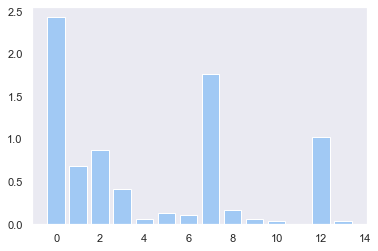

In [23]:
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

## Logistic Regression Model Building and testing

In [24]:
model = LogisticRegression()
y_train = np.ravel(y_train)
model.fit(X_train, y_train)

LogisticRegression()

In [25]:
score = model.score(X_test, y_test)
print(score)

0.9963436928702011


In [26]:
y_pred = model.predict(X_test)
cm = confusion_matrix(np.array(y_test), y_pred)

## Accuracy Matrix

AxesSubplot(0.125,0.125;0.62x0.755)


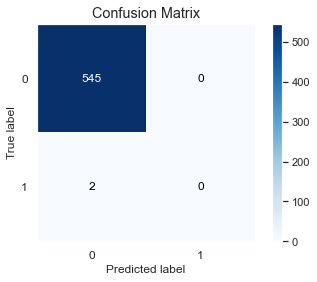

In [27]:
print(skplt.plot_confusion_matrix(y_test,y_pred))

 Due to unbalanced data the final accuracy matrix was unfavourable. Thus SMOTE optimization was used to handle the skewed data.

### After using SMOTE

In [31]:
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (2209, 14) (2209, 1)
Test (1089, 14) (1089, 1)


In [32]:
fs = SelectKBest(score_func=chi2, k=10)
fs.fit(X_train, y_train)
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)

cms = X_train.columns
for i in range(len(fs.scores_)):
    print(f"{i}. {cms[i]}: {fs.scores_[i]}")

0. Above 60: 867.2683881798382
1. BENE_SEX_IDENT_CD_Female: 211.22758755269098
2. BENE_SEX_IDENT_CD_Male: 93.64075163794864
3. BENE_RACE_CD_Black: 118.31180811808116
4. BENE_RACE_CD_Hispanic: 18.680811808118083
5. BENE_RACE_CD_Other: 37.361623616236166
6. BENE_RACE_CD_White: 14.35154968894127
7. SP_CHF: 483.62546125461256
8. SP_COPD: 292.8536275324822
9. SP_DEPRESSN: 246.35494466479162
10. SP_DIABETES: 355.0226347882554
11. SP_ISCHMCHT: 280.30242644915495
12. SP_OSTEOPRS: 529.2354783579362
13. SP_STRKETIA: 29.695408190960464


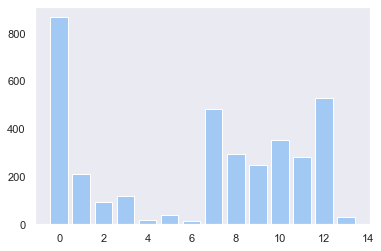

In [33]:
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

In [34]:
model = LogisticRegression()
y_train = np.ravel(y_train)
model.fit(X_train, y_train)

LogisticRegression()

In [35]:
score = model.score(X_test, y_test)
print(score)

0.9632690541781451


In [36]:
y_pred = model.predict(X_test)
cm = confusion_matrix(np.array(y_test), y_pred)

## Final Accuracy matrix

AxesSubplot(0.125,0.125;0.62x0.755)


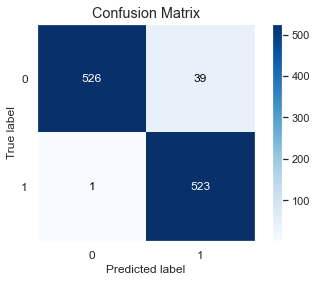

In [37]:
print(skplt.plot_confusion_matrix(y_test,y_pred))